# 5. Classification: Predicting Diabetes Risk

## CRISP-DM Phase 4: Modelling

This notebook implements classification models to predict diabetes status using the CDC Diabetes Health Indicators dataset. We compare:

1. **Binary Classification**: "At-Risk" (prediabetes + diabetes) vs "Healthy"
2. **Multiclass Classification**: Healthy (0), Prediabetes (1), Diabetes (2)

We also compare:
- **Engineered features** (from notebook 2) vs **Raw features**
- **Four resampling strategies**: No resampling (baseline), SMOTE, RandomOverSampler, Class Weights

### Clinical Rationale
Treating prediabetes as "at-risk" enables early intervention - individuals with prediabetes can reverse their condition through lifestyle changes, making early detection clinically valuable.

---
## 5.1 Setup and Configuration

In [ ]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
from pathlib import Path

# Sklearn - preprocessing and model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline

# Sklearn - models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Sklearn - metrics
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, classification_report, roc_auc_score,
    log_loss, roc_curve, auc
)

# Sklearn - calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Sklearn - feature selection
from sklearn.feature_selection import RFECV

# Imbalanced-learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Explainability
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Constants
RANDOM_STATE = 42
TEST_SIZE = 0.20
CV_FOLDS = 5
FIGURES_DIR = Path('figures')
DATA_DIR = Path('data')
FIGURES_DIR.mkdir(exist_ok=True)

# Cost parameters for clinical decision making

COST_FP = 5.0    # Cost of false positive (flagging healthy as at-risk)print("Setup complete!")

COST_FN = 25.0   # Cost of false negative (missing at-risk individual)
COST_REVIEW = 2.0  # Cost of sending case for human review

Setup complete!


c:\Users\amyna\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## 5.2 Data Loading

We load both raw features and engineered features to compare their effectiveness.

In [2]:
# Load raw data
df_raw = pd.read_csv('CDC Diabetes Dataset (4).csv')
print(f"Raw dataset shape: {df_raw.shape}")

# Load engineered features from notebook 2
df_engineered = pd.read_csv(DATA_DIR / 'classification_features.csv')
print(f"Engineered dataset shape: {df_engineered.shape}")

# Display engineered features
print(f"\nEngineered features: {list(df_engineered.columns)}")

Raw dataset shape: (253680, 22)
Engineered dataset shape: (253680, 14)

Engineered features: ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'bmi_category', 'cardio_metabolic_risk', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'CholCheck', 'Diabetes_012']


In [3]:
# Define feature columns
RAW_FEATURE_COLS = [col for col in df_raw.columns if col != 'Diabetes_012']
ENGINEERED_FEATURE_COLS = [col for col in df_engineered.columns if col != 'Diabetes_012']

print(f"Raw features ({len(RAW_FEATURE_COLS)}): {RAW_FEATURE_COLS}")
print(f"\nEngineered features ({len(ENGINEERED_FEATURE_COLS)}): {ENGINEERED_FEATURE_COLS}")

Raw features (21): ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']

Engineered features (13): ['lifestyle_risk_score', 'limited_access_to_care', 'age_group', 'income_bracket', 'education_bracket', 'bmi_category', 'cardio_metabolic_risk', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'CholCheck']


---
## 5.2.1 Recursive Feature Elimination (RFE) on Raw Features

Since raw features include 21 variables with potentially redundant information, we apply RFECV to identify the most predictive subset. This can improve model performance and interpretability.

In [ ]:
# Recursive Feature Elimination with Cross-Validation (RFECV)
# Applied to raw features to identify optimal feature subset
# Using Pipeline to prevent data leakage (as per lab best practices)
#
# NOTE: This exploratory analysis identifies the optimal feature subset.
# The selected features will be used in Track E for proper evaluation.

print("=== RFECV on Raw Features ===\n")

# Create binary target for RFE (same logic as Section 5.3)
# This is needed here since RFE runs before the main target creation
df_raw['at_risk'] = (df_raw['Diabetes_012'] >= 1).astype(int)

# Prepare data for RFE
X_raw = df_raw[RAW_FEATURE_COLS]
y_raw_binary = df_raw['at_risk']

# Split for RFE
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(
    X_raw, y_raw_binary, test_size=TEST_SIZE, stratify=y_raw_binary, random_state=RANDOM_STATE
)

# Define CV strategy
cv_rfe = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# IMPORTANT: Use Pipeline to wrap scaling + RFECV to prevent data leakage
# The scaling must happen inside cross-validation, not before
rfecv_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("select", RFECV(
        estimator=LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE),
        step=1,
        cv=cv_rfe,
        scoring="roc_auc",  # Use ROC-AUC for ranking performance
        min_features_to_select=1,  # Allow full exploration
        n_jobs=-1
    ))
])

print("Running RFECV pipeline... (this may take a moment)")
rfecv_pipeline.fit(X_train_rfe, y_train_rfe)

# Extract RFECV results
rfecv = rfecv_pipeline.named_steps["select"]

# Results
print(f"\nOptimal number of features: {rfecv.n_features_}")
print(f"Best CV score (ROC-AUC): {rfecv.cv_results_['mean_test_score'].max():.4f}")

# Selected features
selected_mask = rfecv.support_
selected_features = [f for f, s in zip(RAW_FEATURE_COLS, selected_mask) if s]
eliminated_features = [f for f, s in zip(RAW_FEATURE_COLS, selected_mask) if not s]

print(f"\nSelected features ({len(selected_features)}):")
for f in selected_features:
    print(f"  - {f}")

if eliminated_features:
    print(f"\nEliminated features ({len(eliminated_features)}):")
    for f in eliminated_features:
        print(f"  - {f}")

# Feature ranking

print("\nFeature rankings (1 = selected):")print(feature_ranking.to_string(index=False))

feature_ranking = pd.DataFrame({}).sort_values('Rank')

    'Feature': RAW_FEATURE_COLS,    'Selected': rfecv.support_
    'Rank': rfecv.ranking_,

In [ ]:
# Visualize RFECV results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot CV scores vs number of features
# Handle different sklearn versions for accessing scores
if hasattr(rfecv, "cv_results_") and "mean_test_score" in rfecv.cv_results_:
    scores = rfecv.cv_results_["mean_test_score"]
    n_features = rfecv.cv_results_.get("n_features", range(1, len(scores) + 1))
    std_scores = rfecv.cv_results_.get("std_test_score", np.zeros_like(scores))
elif hasattr(rfecv, "grid_scores_"):
    scores = rfecv.grid_scores_
    n_features = range(1, len(scores) + 1)
    std_scores = np.zeros_like(scores)
else:
    scores = rfecv.cv_results_["mean_test_score"]
    n_features = range(rfecv.min_features_to_select, rfecv.min_features_to_select + len(scores))
    std_scores = rfecv.cv_results_.get("std_test_score", np.zeros_like(scores))

axes[0].plot(n_features, scores, 'b-', linewidth=2, label='Mean CV Score')
axes[0].fill_between(n_features, 
                      scores - std_scores, 
                      scores + std_scores, 
                      alpha=0.2, color='blue')
axes[0].axvline(x=rfecv.n_features_, color='red', linestyle='--', label=f'Optimal ({rfecv.n_features_} features)')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('Cross-validated ROC-AUC')
axes[0].set_title('RFECV: Feature Selection Performance', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart of feature importance (by rank)
colors = ['#2ecc71' if s else '#e74c3c' for s in rfecv.support_]
sorted_idx = np.argsort(rfecv.ranking_)
axes[1].barh(range(len(RAW_FEATURE_COLS)), 
             [rfecv.ranking_[i] for i in sorted_idx],
             color=[colors[i] for i in sorted_idx])
axes[1].set_yticks(range(len(RAW_FEATURE_COLS)))
axes[1].set_yticklabels([RAW_FEATURE_COLS[i] for i in sorted_idx])
axes[1].set_xlabel('Ranking (1 = most important)')
axes[1].set_title('Feature Rankings from RFECV', fontweight='bold')
axes[1].invert_xaxis()  # Lower rank = better

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rfecv_feature_selection.png', dpi=150, bbox_inches='tight')
plt.show()

# Store selected features for later use
RFE_SELECTED_FEATURES = selected_features.copy()
print(f"\nRFE-selected features stored: {len(RFE_SELECTED_FEATURES)} features")

---
## 5.3 Target Variable Creation

We create two target variables:
1. **Binary (at_risk)**: Combines prediabetes (1) and diabetes (2) into "At-Risk" category
2. **Multiclass**: Original 3-class target (0=Healthy, 1=Prediabetes, 2=Diabetes)

In [4]:
# Create binary target: At-Risk (prediabetes + diabetes) vs Healthy
df_raw['at_risk'] = (df_raw['Diabetes_012'] >= 1).astype(int)
df_engineered['at_risk'] = (df_engineered['Diabetes_012'] >= 1).astype(int)

# Display class distributions
print("=== Multiclass Target Distribution ===")
print(df_raw['Diabetes_012'].value_counts().sort_index())
print(f"\nClass proportions:")
print(df_raw['Diabetes_012'].value_counts(normalize=True).sort_index().round(4))

print("\n=== Binary Target Distribution (At-Risk) ===")
print(df_raw['at_risk'].value_counts().sort_index())
print(f"\nClass proportions:")
print(df_raw['at_risk'].value_counts(normalize=True).sort_index().round(4))

=== Multiclass Target Distribution ===
Diabetes_012
0.0    213703
1.0      4631
2.0     35346
Name: count, dtype: int64

Class proportions:
Diabetes_012
0.0    0.8424
1.0    0.0183
2.0    0.1393
Name: proportion, dtype: float64

=== Binary Target Distribution (At-Risk) ===
at_risk
0    213703
1     39977
Name: count, dtype: int64

Class proportions:
at_risk
0    0.8424
1    0.1576
Name: proportion, dtype: float64


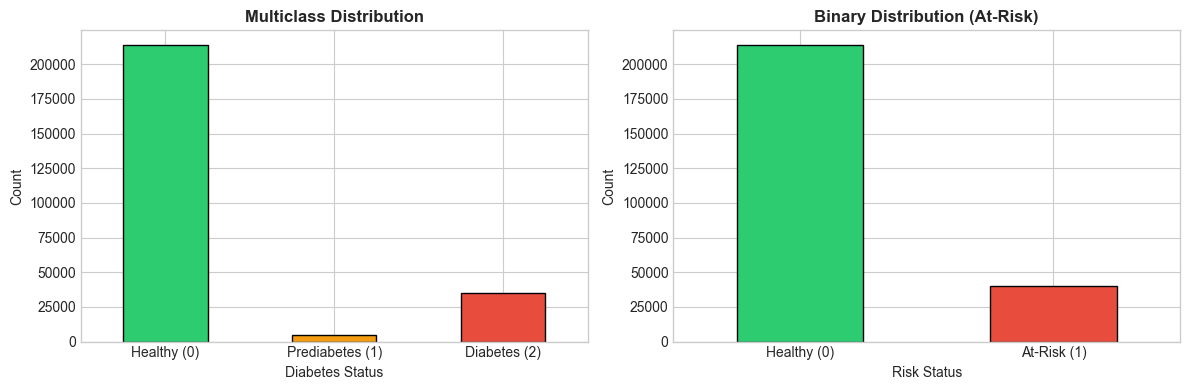

In [5]:
# Visualize class distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Multiclass
class_labels_multi = ['Healthy (0)', 'Prediabetes (1)', 'Diabetes (2)']
colors_multi = ['#2ecc71', '#f39c12', '#e74c3c']
df_raw['Diabetes_012'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color=colors_multi, edgecolor='black'
)
axes[0].set_title('Multiclass Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Diabetes Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(class_labels_multi, rotation=0)

# Binary
class_labels_binary = ['Healthy (0)', 'At-Risk (1)']
colors_binary = ['#2ecc71', '#e74c3c']
df_raw['at_risk'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color=colors_binary, edgecolor='black'
)
axes[1].set_title('Binary Distribution (At-Risk)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Risk Status')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(class_labels_binary, rotation=0)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'class_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5.4 Train/Test Split

We create train/test splits for all four experimental tracks.

In [ ]:
# Define track configurations
# Track E uses RFE-selected features from Section 5.2.1 (requires running that section first)
track_configs = {
    'A': {'name': 'Binary + Engineered',     'features': ENGINEERED_FEATURE_COLS, 'target': 'at_risk',      'df': df_engineered, 'n_classes': 2},
    'B': {'name': 'Binary + Raw',            'features': RAW_FEATURE_COLS,        'target': 'at_risk',      'df': df_raw,        'n_classes': 2},
    'C': {'name': 'Multiclass + Engineered', 'features': ENGINEERED_FEATURE_COLS, 'target': 'Diabetes_012', 'df': df_engineered, 'n_classes': 3},
    'D': {'name': 'Multiclass + Raw',        'features': RAW_FEATURE_COLS,        'target': 'Diabetes_012', 'df': df_raw,        'n_classes': 3},
    'E': {'name': 'Binary + RFE-Selected',   'features': RFE_SELECTED_FEATURES,   'target': 'at_risk',      'df': df_raw,        'n_classes': 2},
}

# Create datasets using configuration
datasets = {}
for track_id, config in track_configs.items():
    X = config['df'][config['features']]
    y = config['df'][config['target']]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    
    datasets[track_id] = {
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'name': config['name'],
        'n_classes': config['n_classes'],
        'features': config['features']
    }

# Summary
print("=== Dataset Summary ===")

for track, data in datasets.items():    print(f"Track {track} ({data['name']}): Train={len(data['X_train'])}, Test={len(data['X_test'])}, Features={len(data['features'])}")

=== Dataset Summary ===
Track A (Binary + Engineered): Train=202944, Test=50736, Features=13
Track B (Binary + Raw): Train=202944, Test=50736, Features=21
Track C (Multiclass + Engineered): Train=202944, Test=50736, Features=13
Track D (Multiclass + Raw): Train=202944, Test=50736, Features=21


---
## 5.5 Model Training Functions

Helper functions for training models with different resampling strategies.

In [7]:
def get_resampling_pipeline(model, resampling_method, n_classes=2):
    """
    Create a pipeline with scaling and optional resampling.
    
    Parameters:
    -----------
    model : sklearn estimator
        The classifier to use
    resampling_method : str
        One of: 'none', 'smote', 'ros', 'class_weight'
    n_classes : int
        Number of classes (2 for binary, 3 for multiclass)
    
    Returns:
    --------
    pipeline : Pipeline or ImbPipeline
    """
    # Determine k_neighbors for SMOTE based on minority class
    k_neighbors = 3 if n_classes == 3 else 5
    
    if resampling_method == 'none':
        return Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
    elif resampling_method == 'smote':
        return ImbPipeline([
            ('scaler', StandardScaler()),
            ('resampler', SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)),
            ('classifier', model)
        ])
    elif resampling_method == 'ros':
        return ImbPipeline([
            ('scaler', StandardScaler()),
            ('resampler', RandomOverSampler(random_state=RANDOM_STATE)),
            ('classifier', model)
        ])
    elif resampling_method == 'class_weight':
        # Clone model with class_weight='balanced'
        model_params = model.get_params()
        model_params['class_weight'] = 'balanced'
        balanced_model = model.__class__(**model_params)
        return Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', balanced_model)
        ])
    else:
        raise ValueError(f"Unknown resampling method: {resampling_method}")


def evaluate_model(model, X_test, y_test, n_classes=2):
    """
    Evaluate a trained model and return metrics dictionary.
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'macro_f1': f1_score(y_test, y_pred, average='macro'),
        'weighted_f1': f1_score(y_test, y_pred, average='weighted'),
        'macro_recall': recall_score(y_test, y_pred, average='macro'),
        'log_loss': log_loss(y_test, y_proba),
    }
    
    # ROC-AUC (handle binary vs multiclass)
    if n_classes == 2:
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba[:, 1])
    else:
        # One-vs-Rest for multiclass
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
        metrics['roc_auc'] = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    
    return metrics, y_pred, y_proba


def train_and_evaluate(X_train, X_test, y_train, y_test, model, resampling_method, n_classes=2):
    """
    Train model with resampling and evaluate.
    """
    start_time = time.time()
    
    pipeline = get_resampling_pipeline(model, resampling_method, n_classes)
    pipeline.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    
    metrics, y_pred, y_proba = evaluate_model(pipeline, X_test, y_test, n_classes)
    metrics['train_time'] = train_time
    
    return pipeline, metrics, y_pred, y_proba

print("Training functions defined!")

Training functions defined!


---
## 5.6 Baseline Models (No Resampling)

First, we establish baseline performance without any resampling to understand the impact of class imbalance.

In [ ]:
# Define base models
# Note: eval_metric='logloss' works for both binary and multiclass in newer XGBoost
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE, 
                             eval_metric='logloss', verbosity=0)
}

# Store all results
all_results = []
trained_models = {}  # Store trained models for later use

print("Training baseline models (no resampling)...\n")

for track_id, track_data in datasets.items():
    print(f"=== Track {track_id}: {track_data['name']} ===")
    trained_models[track_id] = {}
    
    for model_name, model in base_models.items():
        pipeline, metrics, y_pred, y_proba = train_and_evaluate(
            track_data['X_train'], track_data['X_test'],
            track_data['y_train'], track_data['y_test'],
            model, resampling_method='none', n_classes=track_data['n_classes']
        )
        
        # Store result
        result = {
            'track': track_id,
            'track_name': track_data['name'],
            'model': model_name,
            'resampling': 'None',
            **metrics
        }
        all_results.append(result)
        trained_models[track_id][f"{model_name}_none"] = pipeline
        
        print(f"  {model_name}: Acc={metrics['accuracy']:.4f}, Macro-F1={metrics['macro_f1']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")
    print()

Training baseline models (no resampling)...

=== Track A: Binary + Engineered ===
  Logistic Regression: Acc=0.8485, Macro-F1=0.5990, ROC-AUC=0.8124
  Random Forest: Acc=0.8492, Macro-F1=0.5716, ROC-AUC=0.8153
  XGBoost: Acc=0.8498, Macro-F1=0.5959, ROC-AUC=0.8172

=== Track B: Binary + Raw ===
  Logistic Regression: Acc=0.8481, Macro-F1=0.5995, ROC-AUC=0.8172
  Random Forest: Acc=0.8509, Macro-F1=0.5661, ROC-AUC=0.8208
  XGBoost: Acc=0.8525, Macro-F1=0.6084, ROC-AUC=0.8248

=== Track C: Multiclass + Engineered ===
  Logistic Regression: Acc=0.8461, Macro-F1=0.3906, ROC-AUC=0.7758
  Random Forest: Acc=0.8478, Macro-F1=0.3731, ROC-AUC=0.7766
  XGBoost: Acc=0.8478, Macro-F1=0.3892, ROC-AUC=0.7798

=== Track D: Multiclass + Raw ===
  Logistic Regression: Acc=0.8455, Macro-F1=0.3916, ROC-AUC=0.7808
  Random Forest: Acc=0.8479, Macro-F1=0.3650, ROC-AUC=0.7814
  XGBoost: Acc=0.8494, Macro-F1=0.3963, ROC-AUC=0.7876



---
## 5.7 Resampling Comparison: SMOTE vs ROS vs Class Weights

Now we compare all three resampling methods across all tracks, alongside the no-resampling baseline from Section 5.6.

In [9]:
from sklearn.base import clone

# Model factory - creates fresh instances to avoid state contamination
def get_base_models():
    return {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_STATE, n_jobs=-1),
        'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=RANDOM_STATE, 
                                 eval_metric='logloss', verbosity=0)
    }

resampling_methods = ['smote', 'ros', 'class_weight']

print("Training models with resampling methods...\n")

for track_id, track_data in datasets.items():
    print(f"=== Track {track_id}: {track_data['name']} ===")
    
    for resampling in resampling_methods:
        print(f"  Resampling: {resampling.upper()}")
        
        for model_name, model in get_base_models().items():
            # Handle XGBoost class weights differently (uses scale_pos_weight)
            if resampling == 'class_weight' and model_name == 'XGBoost':
                if track_data['n_classes'] == 2:
                    neg_count = (track_data['y_train'] == 0).sum()
                    pos_count = (track_data['y_train'] == 1).sum()
                    model.set_params(scale_pos_weight=neg_count/pos_count)
                else:
                    # For multiclass, compute sample weights instead
                    from sklearn.utils.class_weight import compute_sample_weight
                    sample_weights = compute_sample_weight('balanced', track_data['y_train'])
                
                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('classifier', model)
                ])
                start_time = time.time()
                if track_data['n_classes'] == 2:
                    pipeline.fit(track_data['X_train'], track_data['y_train'])
                else:
                    pipeline.fit(track_data['X_train'], track_data['y_train'], 
                                classifier__sample_weight=sample_weights)
                train_time = time.time() - start_time
                
                metrics, y_pred, y_proba = evaluate_model(
                    pipeline, track_data['X_test'], track_data['y_test'], track_data['n_classes']
                )
                metrics['train_time'] = train_time
            else:
                pipeline, metrics, y_pred, y_proba = train_and_evaluate(
                    track_data['X_train'], track_data['X_test'],
                    track_data['y_train'], track_data['y_test'],
                    model, resampling_method=resampling, n_classes=track_data['n_classes']
                )
            
            # Store result
            result = {
                'track': track_id,
                'track_name': track_data['name'],
                'model': model_name,
                'resampling': resampling.upper(),
                **metrics
            }
            all_results.append(result)
            trained_models[track_id][f"{model_name}_{resampling}"] = pipeline
            
            print(f"    {model_name}: Macro-F1={metrics['macro_f1']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")
    print()

Training models with resampling methods...

=== Track A: Binary + Engineered ===
  Resampling: SMOTE
    Logistic Regression: Macro-F1=0.6385, ROC-AUC=0.8121
    Random Forest: Macro-F1=0.6543, ROC-AUC=0.8116
    XGBoost: Macro-F1=0.6636, ROC-AUC=0.8038
  Resampling: ROS
    Logistic Regression: Macro-F1=0.6391, ROC-AUC=0.8126
    Random Forest: Macro-F1=0.6362, ROC-AUC=0.8158
    XGBoost: Macro-F1=0.6327, ROC-AUC=0.8169
  Resampling: CLASS_WEIGHT
    Logistic Regression: Macro-F1=0.6387, ROC-AUC=0.8126
    Random Forest: Macro-F1=0.6350, ROC-AUC=0.8153
    XGBoost: Macro-F1=0.6318, ROC-AUC=0.8170

=== Track B: Binary + Raw ===
  Resampling: SMOTE
    Logistic Regression: Macro-F1=0.6449, ROC-AUC=0.8165
    Random Forest: Macro-F1=0.6702, ROC-AUC=0.8149
    XGBoost: Macro-F1=0.6691, ROC-AUC=0.8202
  Resampling: ROS
    Logistic Regression: Macro-F1=0.6454, ROC-AUC=0.8176
    Random Forest: Macro-F1=0.6413, ROC-AUC=0.8206
    XGBoost: Macro-F1=0.6387, ROC-AUC=0.8240
  Resampling: CLASS_

In [10]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame(all_results)

# Display results sorted by Macro-F1
print("=== All Results (sorted by Macro-F1) ===")
display_cols = ['track_name', 'model', 'resampling', 'accuracy', 'macro_f1', 'roc_auc', 'macro_recall']
results_df[display_cols].sort_values('macro_f1', ascending=False).head(20)

=== All Results (sorted by Macro-F1) ===


,track_name,model,resampling,accuracy,macro_f1,roc_auc,macro_recall
22,Binary + Raw,Random Forest,SMOTE,0.778225,0.670189,0.814852,0.727439
23,Binary + Raw,XGBoost,SMOTE,0.841809,0.669066,0.820246,0.653532
14,Binary + Engineered,XGBoost,SMOTE,0.786069,0.663558,0.803823,0.702099
13,Binary + Engineered,Random Forest,SMOTE,0.751084,0.654343,0.811641,0.732176
24,Binary + Raw,Logistic Regression,ROS,0.730901,0.645422,0.817584,0.743227
21,Binary + Raw,Logistic Regression,SMOTE,0.730901,0.644932,0.816524,0.741855
27,Binary + Raw,Logistic Regression,CLASS_WEIGHT,0.730369,0.644874,0.817564,0.742657
28,Binary + Raw,Random Forest,CLASS_WEIGHT,0.727531,0.642480,0.820533,0.741074
25,Binary + Raw,Random Forest,ROS,0.725244,0.641301,0.820607,0.741903
15,Binary + Engineered,Logistic Regression,ROS,0.722800,0.639060,0.812579,0.739995


---
## 5.8 Results Visualization

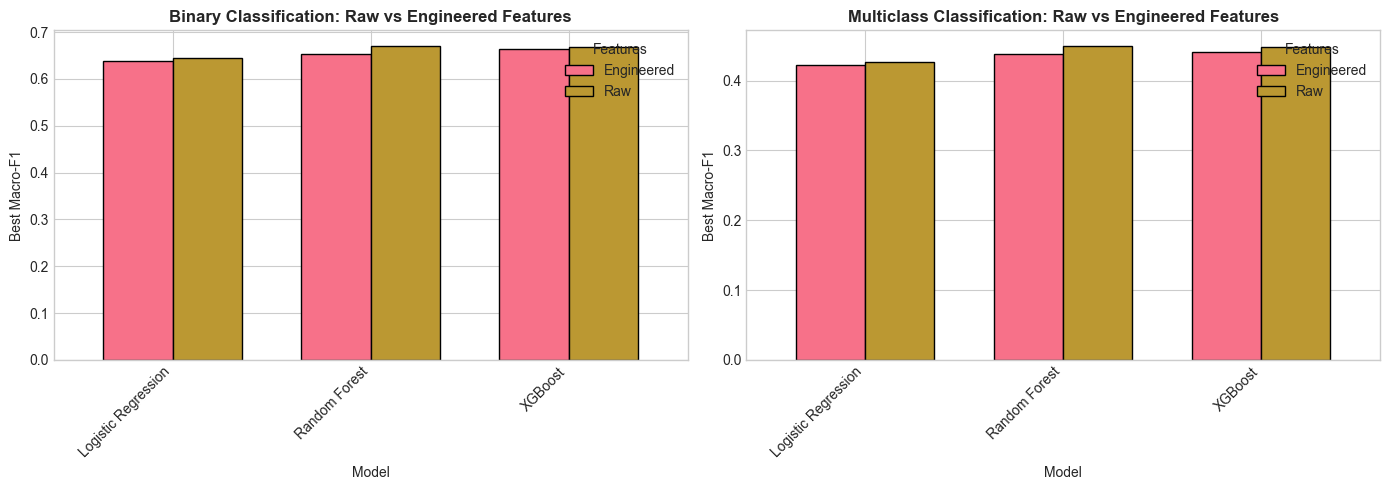

In [33]:
# Comparison: Raw vs Engineered Features
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary comparison
binary_results = results_df[results_df['track'].isin(['A', 'B'])].copy()
binary_results['feature_type'] = binary_results['track'].map({'A': 'Engineered', 'B': 'Raw'})

binary_pivot = binary_results.groupby(['model', 'feature_type'])['macro_f1'].max().unstack()
binary_pivot.plot(kind='bar', ax=axes[0], width=0.7, edgecolor='black')
axes[0].set_title('Binary Classification: Raw vs Engineered Features', fontweight='bold')
axes[0].set_ylabel('Best Macro-F1')
axes[0].set_xlabel('Model')
axes[0].legend(title='Features')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Multiclass comparison
multi_results = results_df[results_df['track'].isin(['C', 'D'])].copy()
multi_results['feature_type'] = multi_results['track'].map({'C': 'Engineered', 'D': 'Raw'})

multi_pivot = multi_results.groupby(['model', 'feature_type'])['macro_f1'].max().unstack()
multi_pivot.plot(kind='bar', ax=axes[1], width=0.7, edgecolor='black')
axes[1].set_title('Multiclass Classification: Raw vs Engineered Features', fontweight='bold')
axes[1].set_ylabel('Best Macro-F1')
axes[1].set_xlabel('Model')
axes[1].legend(title='Features')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'raw_vs_engineered_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

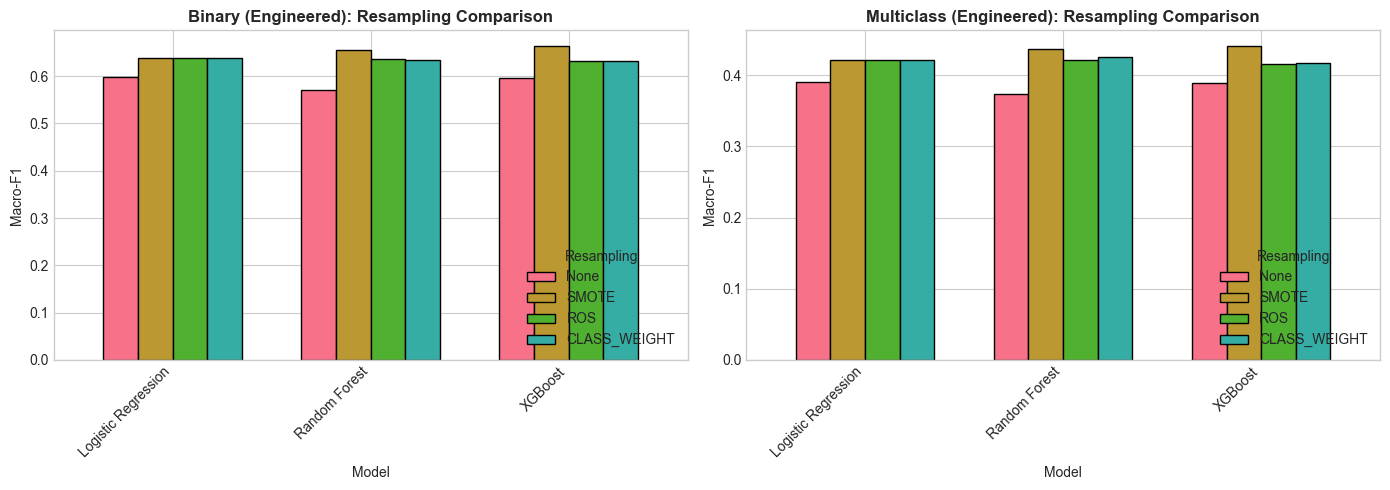

In [12]:
# Comparison: Resampling Methods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary - best track only (pick A or B based on overall performance)
best_binary = results_df[results_df['track'] == 'A']  # Engineered features
resample_pivot_bin = best_binary.pivot_table(
    index='model', columns='resampling', values='macro_f1', aggfunc='first'
).reindex(columns=['None', 'SMOTE', 'ROS', 'CLASS_WEIGHT'])

resample_pivot_bin.plot(kind='bar', ax=axes[0], width=0.7, edgecolor='black')
axes[0].set_title('Binary (Engineered): Resampling Comparison', fontweight='bold')
axes[0].set_ylabel('Macro-F1')
axes[0].set_xlabel('Model')
axes[0].legend(title='Resampling', loc='lower right')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Multiclass - best track
best_multi = results_df[results_df['track'] == 'C']  # Engineered features
resample_pivot_multi = best_multi.pivot_table(
    index='model', columns='resampling', values='macro_f1', aggfunc='first'
).reindex(columns=['None', 'SMOTE', 'ROS', 'CLASS_WEIGHT'])

resample_pivot_multi.plot(kind='bar', ax=axes[1], width=0.7, edgecolor='black')
axes[1].set_title('Multiclass (Engineered): Resampling Comparison', fontweight='bold')
axes[1].set_ylabel('Macro-F1')
axes[1].set_xlabel('Model')
axes[1].legend(title='Resampling', loc='lower right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'resampling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5.9 Hyperparameter Tuning (Best Model)

We perform GridSearchCV on the best-performing model configuration.

In [13]:
# Identify best model configuration
best_config = results_df.loc[results_df['macro_f1'].idxmax()]
print(f"Best configuration so far:")
print(f"  Track: {best_config['track_name']}")
print(f"  Model: {best_config['model']}")
print(f"  Resampling: {best_config['resampling']}")
print(f"  Macro-F1: {best_config['macro_f1']:.4f}")

Best configuration so far:
  Track: Binary + Raw
  Model: Random Forest
  Resampling: SMOTE
  Macro-F1: 0.6702


In [14]:
# GridSearchCV for XGBoost (typically best performer)
# Using Track A (Binary + Engineered) for demonstration

print("Running GridSearchCV for XGBoost with Class Weights...")

# Define parameter grid with actual variation
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0]
}

# Setup pipeline with class weights
neg_count = (datasets['A']['y_train'] == 0).sum()
pos_count = (datasets['A']['y_train'] == 1).sum()

xgb_tuned = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    verbosity=0,
    scale_pos_weight=neg_count/pos_count
)

pipeline_tuned = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb_tuned)
])

# GridSearchCV
grid_search = GridSearchCV(
    pipeline_tuned,
    param_grid,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(datasets['A']['X_train'], datasets['A']['y_train'])

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV Macro-F1: {grid_search.best_score_:.4f}")

Running GridSearchCV for XGBoost with Class Weights...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best CV Macro-F1: 0.6356


In [15]:
# Evaluate tuned model on test set
best_model = grid_search.best_estimator_

metrics_tuned, y_pred_tuned, y_proba_tuned = evaluate_model(
    best_model, datasets['A']['X_test'], datasets['A']['y_test'], n_classes=2
)

print("=== Tuned XGBoost Performance (Binary + Engineered) ===")
for metric, value in metrics_tuned.items():
    print(f"  {metric}: {value:.4f}")

# Store as final model for binary
final_model_binary = best_model
final_track_binary = 'A'

=== Tuned XGBoost Performance (Binary + Engineered) ===
  accuracy: 0.7188
  macro_f1: 0.6360
  weighted_f1: 0.7549
  macro_recall: 0.7384
  log_loss: 0.5190
  roc_auc: 0.8111


In [16]:
# Similarly tune for multiclass (Track C) - with sample weights for class imbalance
print("Running GridSearchCV for XGBoost Multiclass with sample weights...")

from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights for the training set
sample_weights_multi = compute_sample_weight('balanced', datasets['C']['y_train'])

xgb_multi = XGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='mlogloss',
    verbosity=0,
    objective='multi:softprob',
    num_class=3
)

pipeline_multi = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', xgb_multi)
])

# Custom scorer that applies sample weights is complex in GridSearchCV
# Alternative: Use a wrapper or fit with sample_weight post-GridSearchCV
# For simplicity, we perform GridSearchCV without weights, then refit best model with weights

grid_search_multi = GridSearchCV(
    pipeline_multi,
    param_grid,
    cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search_multi.fit(datasets['C']['X_train'], datasets['C']['y_train'])

print(f"\nBest parameters from GridSearchCV: {grid_search_multi.best_params_}")
print(f"Best CV Macro-F1 (without weights): {grid_search_multi.best_score_:.4f}")

# Refit with best parameters AND sample weights
print("\nRefitting best model with sample weights for class imbalance...")
best_params = {k.replace('classifier__', ''): v for k, v in grid_search_multi.best_params_.items()}

xgb_multi_weighted = XGBClassifier(
    **best_params,
    random_state=RANDOM_STATE,
    eval_metric='mlogloss',
    verbosity=0,
    objective='multi:softprob',
    num_class=3
)

scaler_multi_final = StandardScaler()
X_train_scaled_multi = scaler_multi_final.fit_transform(datasets['C']['X_train'])
X_test_scaled_multi = scaler_multi_final.transform(datasets['C']['X_test'])

xgb_multi_weighted.fit(X_train_scaled_multi, datasets['C']['y_train'], sample_weight=sample_weights_multi)

# Create a pipeline-like wrapper for consistency
class WeightedPipelineWrapper:
    """Wrapper to maintain pipeline-like interface for weighted model."""
    def __init__(self, scaler, classifier):
        self.named_steps = {'scaler': scaler, 'classifier': classifier}
    def predict(self, X):
        X_scaled = self.named_steps['scaler'].transform(X)
        return self.named_steps['classifier'].predict(X_scaled)
    def predict_proba(self, X):
        X_scaled = self.named_steps['scaler'].transform(X)
        return self.named_steps['classifier'].predict_proba(X_scaled)

best_model_multi = WeightedPipelineWrapper(scaler_multi_final, xgb_multi_weighted)

# Evaluate
metrics_tuned_multi, y_pred_tuned_multi, y_proba_tuned_multi = evaluate_model(
    best_model_multi, datasets['C']['X_test'], datasets['C']['y_test'], n_classes=3
)

print("\n=== Tuned XGBoost Performance (Multiclass + Engineered + Sample Weights) ===")
for metric, value in metrics_tuned_multi.items():
    print(f"  {metric}: {value:.4f}")

final_model_multiclass = best_model_multi
final_track_multiclass = 'C'

Running GridSearchCV for XGBoost Multiclass with sample weights...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Best parameters from GridSearchCV: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best CV Macro-F1 (without weights): 0.3913

Refitting best model with sample weights for class imbalance...

=== Tuned XGBoost Performance (Multiclass + Engineered + Sample Weights) ===
  accuracy: 0.6451
  macro_f1: 0.4147
  weighted_f1: 0.7132
  macro_recall: 0.4963
  log_loss: 0.7819
  roc_auc: 0.7279


---
## 5.10 Bootstrap Confidence Intervals

We compute bootstrap confidence intervals on test set metrics to quantify uncertainty without data leakage. This is methodologically superior to running CV on an already-tuned model, which would introduce optimistic bias.

In [17]:
# Bootstrap Confidence Intervals for Test Set Metrics
# This is methodologically correct: we avoid data leakage by only using the held-out test set
# Bootstrap resampling provides confidence intervals without re-training

from sklearn.utils import resample

def bootstrap_metrics(y_true, y_pred, y_proba, n_classes, n_bootstrap=1000, ci=95):
    """
    Compute bootstrap confidence intervals for classification metrics on test set.
    """
    np.random.seed(RANDOM_STATE)
    n_samples = len(y_true)
    
    metrics_bootstrap = {
        'accuracy': [], 'macro_f1': [], 'roc_auc': []
    }
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_pred_boot = y_pred[indices]
        y_proba_boot = y_proba[indices]
        
        # Skip if bootstrap sample has single class
        if len(np.unique(y_true_boot)) < 2:
            continue
            
        metrics_bootstrap['accuracy'].append(accuracy_score(y_true_boot, y_pred_boot))
        metrics_bootstrap['macro_f1'].append(f1_score(y_true_boot, y_pred_boot, average='macro'))
        
        if n_classes == 2:
            try:
                metrics_bootstrap['roc_auc'].append(roc_auc_score(y_true_boot, y_proba_boot[:, 1]))
            except:
                pass
        else:
            try:
                y_true_bin = label_binarize(y_true_boot, classes=[0, 1, 2])
                metrics_bootstrap['roc_auc'].append(
                    roc_auc_score(y_true_bin, y_proba_boot, average='macro', multi_class='ovr')
                )
            except:
                pass
    
    # Compute confidence intervals
    alpha = (100 - ci) / 2
    results = {}
    for metric, values in metrics_bootstrap.items():
        if len(values) > 0:
            results[metric] = {
                'mean': np.mean(values),
                'ci_lower': np.percentile(values, alpha),
                'ci_upper': np.percentile(values, 100 - alpha),
                'std': np.std(values)
            }
    return results

print("=== Bootstrap Confidence Intervals: Binary Model (Test Set) ===")
print("(1000 bootstrap samples, 95% CI)\n")

ci_binary = bootstrap_metrics(
    datasets['A']['y_test'], y_pred_tuned, y_proba_tuned, n_classes=2
)

for metric, stats in ci_binary.items():
    print(f"  {metric}: {stats['mean']:.4f} (95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}])")

# Store for summary section
cv_scores_binary = {k: np.array([v['mean']]) for k, v in ci_binary.items()}
cv_scores_binary['f1_macro'] = np.array([ci_binary['macro_f1']['mean']])

print("\n=== Bootstrap Confidence Intervals: Multiclass Model (Test Set) ===")

ci_multi = bootstrap_metrics(
    datasets['C']['y_test'], y_pred_tuned_multi, y_proba_tuned_multi, n_classes=3
)

for metric, stats in ci_multi.items():
    print(f"  {metric}: {stats['mean']:.4f} (95% CI: [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}])")

cv_scores_multi = {k: np.array([v['mean']]) for k, v in ci_multi.items()}
cv_scores_multi['f1_macro'] = np.array([ci_multi['macro_f1']['mean']])

=== Bootstrap Confidence Intervals: Binary Model (Test Set) ===
(1000 bootstrap samples, 95% CI)

  accuracy: 0.7187 (95% CI: [0.7148, 0.7227])
  macro_f1: 0.6359 (95% CI: [0.6310, 0.6405])
  roc_auc: 0.8110 (95% CI: [0.8062, 0.8156])

=== Bootstrap Confidence Intervals: Multiclass Model (Test Set) ===
  accuracy: 0.6451 (95% CI: [0.6409, 0.6492])
  macro_f1: 0.4147 (95% CI: [0.4109, 0.4190])
  roc_auc: 0.7280 (95% CI: [0.7209, 0.7354])


---
## 5.11 Probabilistic Classification & Calibration

In clinical decision support, we need more than just class predictions—we need **trustworthy probabilities** to:
- Quantify model confidence for each prediction
- Enable cost-sensitive threshold selection based on clinical trade-offs
- Identify uncertain cases for human review (triage)

We'll assess probability calibration using:
- **Brier Score**: Mean squared error of probabilities (lower = better)
- **Log Loss**: Penalizes confident wrong predictions severely
- **Reliability Diagrams**: Visual check that predicted probabilities match actual outcomes

Two calibration methods will be compared:
- **Sigmoid (Platt Scaling)**: Fits S-shaped curve; robust default
- **Isotonic Regression**: More flexible; can overfit with limited data

=== Probability Calibration Analysis ===


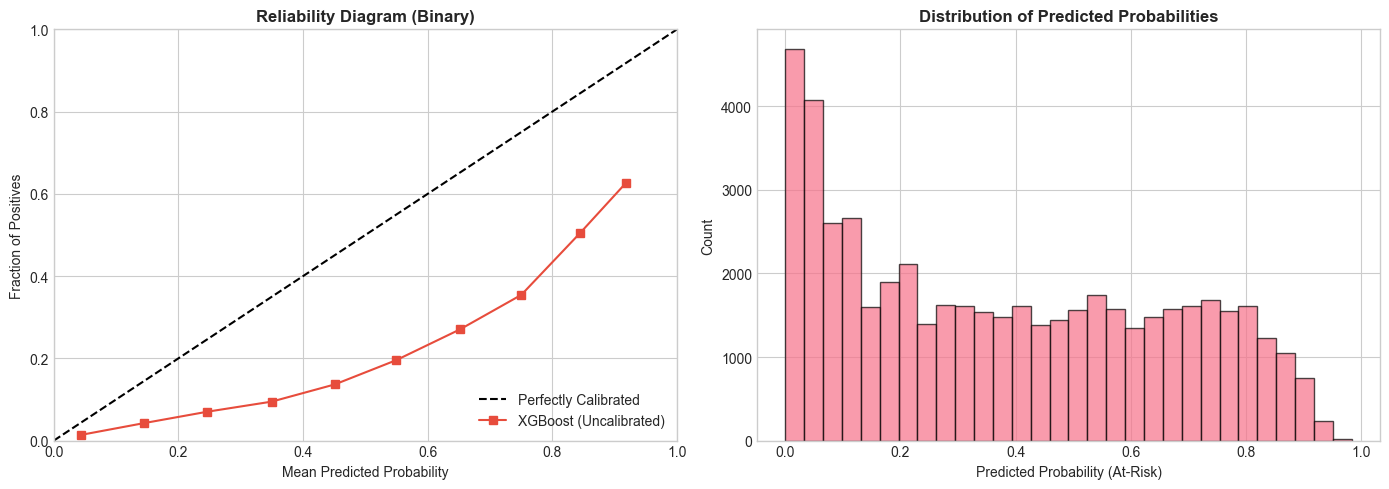

In [ ]:
# Probability Calibration Analysis - Binary Model
# Following probabilistic classification best practices

from sklearn.metrics import brier_score_loss, average_precision_score, precision_recall_curve

def evaluate_probabilistic(y_true, proba, name, threshold=0.5):
    """
    Comprehensive probabilistic classification evaluation.
    Includes both threshold-dependent and probability-quality metrics.
    """
    y_pred = (proba >= threshold).astype(int)
    
    return {
        "model": name,
        "threshold": threshold,
        # Threshold-dependent metrics
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        # Ranking metrics (threshold-independent)
        "roc_auc": roc_auc_score(y_true, proba),
        "avg_precision": average_precision_score(y_true, proba),
        # Probability-quality metrics
        "log_loss": log_loss(y_true, proba),
        "brier_score": brier_score_loss(y_true, proba),
    }

print("=== Probabilistic Classification Analysis ===\n")

# Get predictions from final binary model
y_test_binary = datasets['A']['y_test']
y_proba_binary = final_model_binary.predict_proba(datasets['A']['X_test'])[:, 1]

# Evaluate uncalibrated model
uncal_metrics = evaluate_probabilistic(y_test_binary, y_proba_binary, "XGBoost (Uncalibrated)")
print("Uncalibrated Model Metrics:")
for k, v in uncal_metrics.items():
    if k != "model":
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_test_binary, y_proba_binary, n_bins=10, strategy='uniform')

# Plot calibration curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reliability diagram
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[0].plot(prob_pred, prob_true, 's-', label='XGBoost (Uncalibrated)', color='#e74c3c')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives')
axes[0].set_title('Reliability Diagram (Binary)', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Histogram of predicted probabilities
axes[1].hist(y_proba_binary, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Predicted Probability (At-Risk)')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Predicted Probabilities', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'calibration_analysis_uncalibrated.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Apply Platt Scaling (Sigmoid Calibration) 
# Using cv=3 with an UNFITTED estimator clone - CalibratedClassifierCV handles cross-validation internally

print("Applying probability calibration...")

from sklearn.base import clone

# Get the scaler from the final model
scaler = final_model_binary.named_steps['scaler']
X_train_scaled = scaler.transform(datasets['A']['X_train'])
X_test_scaled = scaler.transform(datasets['A']['X_test'])

# Create unfitted XGBoost estimators with the best hyperparameters for calibration
# This is the correct pattern: pass unfitted estimators, let CalibratedClassifierCV handle CV internally
best_params = {k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items()}

xgb_for_sigmoid = XGBClassifier(
    **best_params,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    verbosity=0,
    scale_pos_weight=neg_count/pos_count
)

xgb_for_isotonic = XGBClassifier(
    **best_params,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    verbosity=0,
    scale_pos_weight=neg_count/pos_count
)

# CalibratedClassifierCV with cv=3: trains 3 folds internally, averages calibrated models
calibrated_sigmoid = CalibratedClassifierCV(xgb_for_sigmoid, method='sigmoid', cv=3)
calibrated_isotonic = CalibratedClassifierCV(xgb_for_isotonic, method='isotonic', cv=3)

# Fit on scaled training data - calibration happens internally via CV
calibrated_sigmoid.fit(X_train_scaled, datasets['A']['y_train'])
calibrated_isotonic.fit(X_train_scaled, datasets['A']['y_train'])

# Get calibrated probabilities on test set
y_proba_sigmoid = calibrated_sigmoid.predict_proba(X_test_scaled)[:, 1]
y_proba_isotonic = calibrated_isotonic.predict_proba(X_test_scaled)[:, 1]

# Get uncalibrated probabilities from original final model for comparison
y_proba_binary = final_model_binary.predict_proba(datasets['A']['X_test'])[:, 1]

# Calculate calibration curves
y_test_binary = datasets['A']['y_test']
prob_true, prob_pred = calibration_curve(y_test_binary, y_proba_binary, n_bins=10, strategy='uniform')
prob_true_sig, prob_pred_sig = calibration_curve(y_test_binary, y_proba_sigmoid, n_bins=10)
prob_true_iso, prob_pred_iso = calibration_curve(y_test_binary, y_proba_isotonic, n_bins=10)

print("Calibration models fitted successfully!")

Applying probability calibration...
Calibration models fitted successfully!


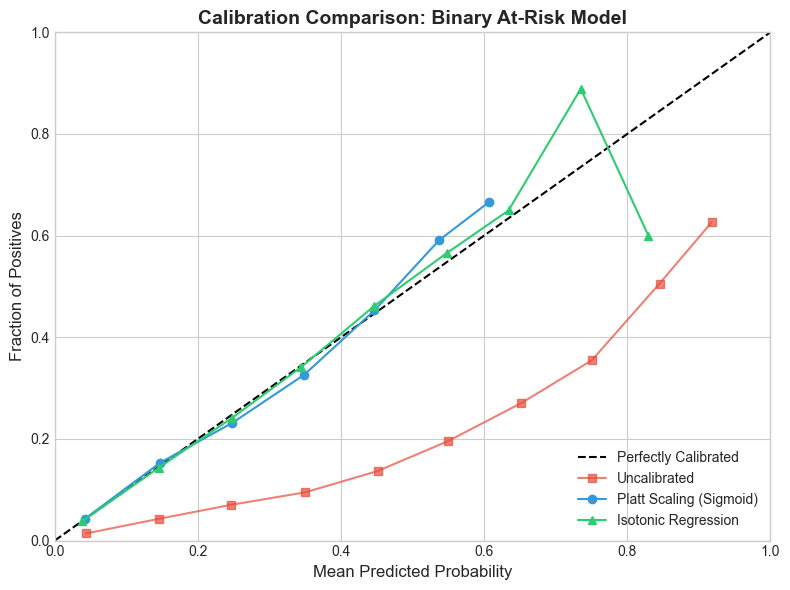


Brier Score (lower is better):
  Uncalibrated: 0.1780
  Sigmoid:      0.1086
  Isotonic:     0.1084


In [ ]:
# Compare calibration methods with comprehensive metrics
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
ax.plot(prob_pred, prob_true, 's-', label='Uncalibrated', color='#e74c3c', alpha=0.7)
ax.plot(prob_pred_sig, prob_true_sig, 'o-', label='Platt Scaling (Sigmoid)', color='#3498db')
ax.plot(prob_pred_iso, prob_true_iso, '^-', label='Isotonic Regression', color='#2ecc71')

ax.set_xlabel('Mean Predicted Probability', fontsize=12)
ax.set_ylabel('Fraction of Positives', fontsize=12)
ax.set_title('Calibration Comparison: Binary At-Risk Model', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'calibration_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Comprehensive metrics comparison (following lab approach)
calibration_results = pd.DataFrame([
    evaluate_probabilistic(y_test_binary, y_proba_binary, "Uncalibrated"),
    evaluate_probabilistic(y_test_binary, y_proba_sigmoid, "Sigmoid Calibration"),
    evaluate_probabilistic(y_test_binary, y_proba_isotonic, "Isotonic Calibration"),
])

print("\n=== Comprehensive Calibration Comparison ===")
display_metrics = ['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'avg_precision', 'log_loss', 'brier_score']
print(calibration_results[display_metrics].to_string(index=False))

# Store Brier scores for backward compatibility
brier_uncal = brier_score_loss(y_test_binary, y_proba_binary)
brier_sigmoid = brier_score_loss(y_test_binary, y_proba_sigmoid)
brier_isotonic = brier_score_loss(y_test_binary, y_proba_isotonic)

print(f"\nBrier Score Summary (lower is better):")
print(f"  Uncalibrated: {brier_uncal:.4f}")
print(f"  Sigmoid:      {brier_sigmoid:.4f}")
print(f"  Isotonic:     {brier_isotonic:.4f}")

In [21]:
# Show example predictions with calibrated probabilities
print("=== Example Predictions with Calibrated Probabilities ===")

# Select best calibrator based on Brier score
if brier_sigmoid < brier_isotonic:
    best_calibrator = calibrated_sigmoid
    calibration_method = 'Sigmoid'
else:
    best_calibrator = calibrated_isotonic
    calibration_method = 'Isotonic'

print(f"Using {calibration_method} calibration (best Brier score)\n")

# Sample predictions
sample_indices = datasets['A']['X_test'].sample(10, random_state=RANDOM_STATE).index
X_sample = datasets['A']['X_test'].loc[sample_indices]
y_sample_true = datasets['A']['y_test'].loc[sample_indices]

y_sample_pred = best_calibrator.predict(X_sample)
y_sample_proba = best_calibrator.predict_proba(X_sample)[:, 1]

sample_results = pd.DataFrame({
    'True Label': y_sample_true.map({0: 'Healthy', 1: 'At-Risk'}),
    'Predicted': pd.Series(y_sample_pred, index=sample_indices).map({0: 'Healthy', 1: 'At-Risk'}),
    'Probability (At-Risk)': y_sample_proba,
    'Confidence': ['High' if p > 0.7 or p < 0.3 else 'Medium' if p > 0.6 or p < 0.4 else 'Low' 
                   for p in y_sample_proba]
})

sample_results

=== Example Predictions with Calibrated Probabilities ===
Using Isotonic calibration (best Brier score)



,True Label,Predicted,Probability (At-Risk),Confidence
165054,Healthy,Healthy,0.418377,Low
56644,Healthy,At-Risk,0.564900,Low
104869,Healthy,Healthy,0.470522,Low
57171,Healthy,At-Risk,0.532233,Low
33429,Healthy,Healthy,0.140291,High
154924,Healthy,Healthy,0.186113,High
69032,Healthy,At-Risk,0.526796,Low
171871,Healthy,Healthy,0.453501,Low
70512,Healthy,Healthy,0.192678,High
182291,Healthy,Healthy,0.102997,High


### 5.11.1 Cost-Based Threshold Selection

In clinical screening, the costs of different errors are asymmetric:
- **False Negative (missing at-risk individual)**: Very costly - missed opportunity for early intervention
- **False Positive (flagging healthy as at-risk)**: Less costly - additional screening burden

We can select an optimal threshold that minimizes expected cost based on these clinical trade-offs.

In [ ]:
# Cost-based threshold selection
# Using calibrated probabilities (best calibrator)
# Note: COST_FP, COST_FN, COST_REVIEW are defined in Section 5.1 Setup

def expected_cost(y_true, proba, threshold, cost_fp=COST_FP, cost_fn=COST_FN):
    """Calculate expected cost given costs of false positives and false negatives."""
    y_pred = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return cost_fp * fp + cost_fn * fn

def sweep_thresholds(y_true, proba, cost_fp=COST_FP, cost_fn=COST_FN, n=401):
    """Find optimal threshold by sweeping across possible values."""
    thresholds = np.linspace(0, 1, n)
    costs = np.array([expected_cost(y_true, proba, t, cost_fp, cost_fn) for t in thresholds])
    best_idx = costs.argmin()
    return thresholds, costs, thresholds[best_idx], costs[best_idx]

# Use best calibrated probabilities
if brier_sigmoid < brier_isotonic:
    best_proba = y_proba_sigmoid
    calib_name = "Sigmoid"
else:
    best_proba = y_proba_isotonic
    calib_name = "Isotonic"

thresholds, costs, optimal_threshold, min_cost = sweep_thresholds(
    y_test_binary, best_proba, cost_fp=COST_FP, cost_fn=COST_FN
)

print(f"=== Cost-Based Threshold Optimization ({calib_name} Calibration) ===")
print(f"Cost assumptions: FP=${COST_FP:.0f}, FN=${COST_FN:.0f} (FN is {COST_FN/COST_FP:.0f}x more costly)")
print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"Minimum expected cost: ${min_cost:.0f}")

# Compare with default threshold
default_cost = expected_cost(y_test_binary, best_proba, 0.5, COST_FP, COST_FN)
print(f"\nComparison:")
print(f"  Default (t=0.50): ${default_cost:.0f}")
print(f"  Optimal (t={optimal_threshold:.2f}): ${min_cost:.0f}")
print(f"  Savings: ${default_cost - min_cost:.0f} ({100*(default_cost-min_cost)/default_cost:.1f}%)")

In [ ]:
# Visualize cost curve and confusion matrices at different thresholds
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Cost curve
axes[0].plot(thresholds, costs, 'b-', linewidth=2)
axes[0].axvline(x=optimal_threshold, color='red', linestyle='--', label=f'Optimal (t={optimal_threshold:.2f})')
axes[0].axvline(x=0.5, color='gray', linestyle=':', label='Default (t=0.50)')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel(f'Expected Cost (FP=${COST_FP:.0f}, FN=${COST_FN:.0f})')
axes[0].set_title('Cost-Based Threshold Selection', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix at default threshold (0.5)
y_pred_default = (best_proba >= 0.5).astype(int)
cm_default = confusion_matrix(y_test_binary, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Healthy', 'At-Risk'], yticklabels=['Healthy', 'At-Risk'])
axes[1].set_title(f'Threshold = 0.50 (Default)\nCost = ${default_cost:.0f}', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Confusion matrix at optimal threshold
y_pred_optimal = (best_proba >= optimal_threshold).astype(int)
cm_optimal = confusion_matrix(y_test_binary, y_pred_optimal)
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Healthy', 'At-Risk'], yticklabels=['Healthy', 'At-Risk'])
axes[2].set_title(f'Threshold = {optimal_threshold:.2f} (Optimal)\nCost = ${min_cost:.0f}', fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cost_based_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

# Show metrics at both thresholds
print("\n=== Metrics Comparison: Default vs Optimal Threshold ===")
metrics_default = evaluate_probabilistic(y_test_binary, best_proba, "Default (t=0.50)", threshold=0.5)
metrics_optimal = evaluate_probabilistic(y_test_binary, best_proba, f"Optimal (t={optimal_threshold:.2f})", threshold=optimal_threshold)

comparison_df = pd.DataFrame([metrics_default, metrics_optimal])
print(comparison_df[['model', 'threshold', 'accuracy', 'precision', 'recall', 'f1']].to_string(index=False))

### 5.11.2 Triage Policy: Auto-Decision vs Human Review

Real clinical decision support systems often use a 3-tier approach:
- **Auto-clear**: If probability is very low → automatically classify as healthy
- **Auto-flag**: If probability is very high → automatically classify as at-risk  
- **Human Review**: For uncertain cases → send to clinician for assessment

This reduces workload while ensuring uncertain cases get expert attention.

In [ ]:
# Triage policy implementation
def triage_policy(proba, low_threshold=0.10, high_threshold=0.80):
    """
    Apply 3-tier triage policy.
    
    Parameters:
    -----------
    proba : array
        Predicted probabilities
    low_threshold : float
        Below this → auto-clear as healthy
    high_threshold : float
        Above this → auto-flag as at-risk
        
    Returns:
    --------
    actions : array of strings
    """
    action = np.full_like(proba, "REVIEW", dtype=object)
    action[proba <= low_threshold] = "AUTO_HEALTHY"
    action[proba >= high_threshold] = "AUTO_AT_RISK"
    return action

def evaluate_triage(y_true, proba, low, high, cost_fp=COST_FP, cost_fn=COST_FN, cost_review=COST_REVIEW):
    """Evaluate total cost under triage policy."""
    actions = triage_policy(proba, low, high)
    
    review_mask = actions == "REVIEW"
    auto_mask = ~review_mask
    
    # Review cost
    total_cost = cost_review * review_mask.sum()
    
    # Auto-decision costs (misclassification)
    if auto_mask.sum() > 0:
        y_auto_true = y_true[auto_mask]
        actions_auto = actions[auto_mask]
        
        # AUTO_HEALTHY → predict 0, AUTO_AT_RISK → predict 1
        y_auto_pred = np.where(actions_auto == "AUTO_HEALTHY", 0, 1)
        
        # Count errors
        fp = ((y_auto_true == 0) & (y_auto_pred == 1)).sum()
        fn = ((y_auto_true == 1) & (y_auto_pred == 0)).sum()
        total_cost += cost_fp * fp + cost_fn * fn
    
    return total_cost, actions

# Test different triage thresholds
print("=== Triage Policy Analysis ===\n")

# Example triage policy
low_t, high_t = 0.10, 0.80
total_cost, actions = evaluate_triage(y_test_binary.values, best_proba, low_t, high_t, COST_FP, COST_FN, COST_REVIEW)

action_counts = pd.Series(actions).value_counts()
print(f"Triage thresholds: low={low_t}, high={high_t}")
print(f"\nAction distribution:")
for action, count in action_counts.items():
    pct = 100 * count / len(actions)
    print(f"  {action}: {count} ({pct:.1f}%)")

print(f"\nTotal cost (FP=${COST_FP}, FN=${COST_FN}, Review=${COST_REVIEW}): ${total_cost:.0f}")

# Compare triage costs
triage_cost = total_cost
binary_cost_default = expected_cost(y_test_binary, best_proba, 0.5, COST_FP, COST_FN)

print(f"\nCost comparison:")
print(f"  Binary classification (t=0.5): ${binary_cost_default:.0f}")
print(f"  Triage policy: ${triage_cost:.0f} (includes ${COST_REVIEW * (actions == 'REVIEW').sum():.0f} review cost)")

In [ ]:
# Grid search for optimal triage thresholds
print("=== Optimizing Triage Thresholds ===\n")

lows = np.linspace(0.05, 0.30, 26)
highs = np.linspace(0.70, 0.95, 26)

best_triage = {'cost': np.inf, 'low': None, 'high': None, 'review_pct': None}

for low in lows:
    for high in highs:
        if low >= high:
            continue
        cost, actions = evaluate_triage(y_test_binary.values, best_proba, low, high, COST_FP, COST_FN, COST_REVIEW)
        if cost < best_triage['cost']:
            best_triage = {
                'cost': cost,
                'low': low,
                'high': high,
                'review_pct': 100 * (actions == 'REVIEW').mean()
            }

print(f"Optimal triage thresholds:")
print(f"  Low threshold (auto-healthy): {best_triage['low']:.3f}")
print(f"  High threshold (auto-at-risk): {best_triage['high']:.3f}")
print(f"  Cases sent to review: {best_triage['review_pct']:.1f}%")
print(f"  Total cost: ${best_triage['cost']:.0f}")

# Final visualization with optimal triage
_, optimal_actions = evaluate_triage(y_test_binary.values, best_proba, best_triage['low'], best_triage['high'], COST_FP, COST_FN, COST_REVIEW)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Probability distribution with triage zones
axes[0].hist(best_proba, bins=50, edgecolor='black', alpha=0.7, color='gray')
axes[0].axvline(x=best_triage['low'], color='green', linestyle='--', linewidth=2, label=f"Auto-healthy (p≤{best_triage['low']:.2f})")
axes[0].axvline(x=best_triage['high'], color='red', linestyle='--', linewidth=2, label=f"Auto-at-risk (p≥{best_triage['high']:.2f})")
axes[0].axvspan(0, best_triage['low'], alpha=0.2, color='green')
axes[0].axvspan(best_triage['high'], 1, alpha=0.2, color='red')
axes[0].axvspan(best_triage['low'], best_triage['high'], alpha=0.2, color='orange')
axes[0].set_xlabel('Predicted Probability (At-Risk)')
axes[0].set_ylabel('Count')
axes[0].set_title('Triage Zones Based on Calibrated Probabilities', fontweight='bold')
axes[0].legend()

# Pie chart of actions
action_counts = pd.Series(optimal_actions).value_counts()
colors = {'AUTO_HEALTHY': '#2ecc71', 'REVIEW': '#f39c12', 'AUTO_AT_RISK': '#e74c3c'}
axes[1].pie(action_counts.values, labels=action_counts.index, autopct='%1.1f%%',
           colors=[colors[a] for a in action_counts.index], startangle=90)
axes[1].set_title('Optimal Triage Action Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'triage_policy.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTriage policy allows automated decisions for most cases while")
print("routing uncertain cases to human experts for review.")

---
## 5.12 Confusion Matrices (Final Models)

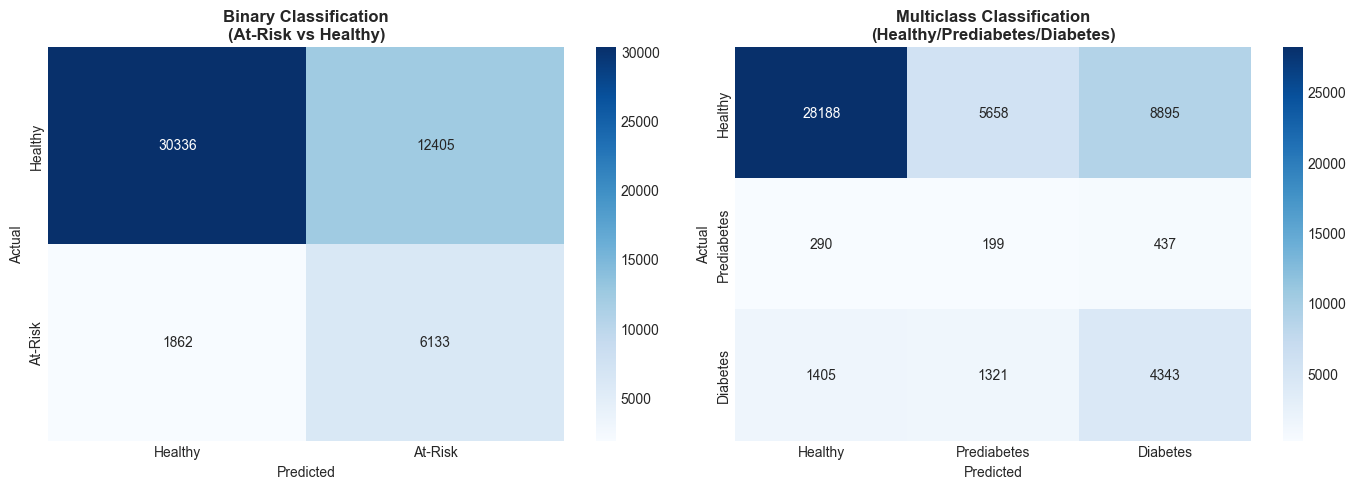

In [22]:
# Confusion matrices for final models
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary
cm_binary = confusion_matrix(y_test_binary, y_pred_tuned)
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Healthy', 'At-Risk'], yticklabels=['Healthy', 'At-Risk'])
axes[0].set_title('Binary Classification\n(At-Risk vs Healthy)', fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Multiclass
cm_multi = confusion_matrix(datasets['C']['y_test'], y_pred_tuned_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Healthy', 'Prediabetes', 'Diabetes'], 
            yticklabels=['Healthy', 'Prediabetes', 'Diabetes'])
axes[1].set_title('Multiclass Classification\n(Healthy/Prediabetes/Diabetes)', fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'final_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
# Detailed classification reports
print("=== Binary Classification Report ===")
print(classification_report(y_test_binary, y_pred_tuned, target_names=['Healthy', 'At-Risk']))

print("\n=== Multiclass Classification Report ===")
print(classification_report(datasets['C']['y_test'], y_pred_tuned_multi, 
                           target_names=['Healthy', 'Prediabetes', 'Diabetes']))

=== Binary Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.94      0.71      0.81     42741
     At-Risk       0.33      0.77      0.46      7995

    accuracy                           0.72     50736
   macro avg       0.64      0.74      0.64     50736
weighted avg       0.85      0.72      0.75     50736


=== Multiclass Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.94      0.66      0.78     42741
 Prediabetes       0.03      0.21      0.05       926
    Diabetes       0.32      0.61      0.42      7069

    accuracy                           0.65     50736
   macro avg       0.43      0.50      0.41     50736
weighted avg       0.84      0.65      0.71     50736



---
## 5.13 ROC Curves

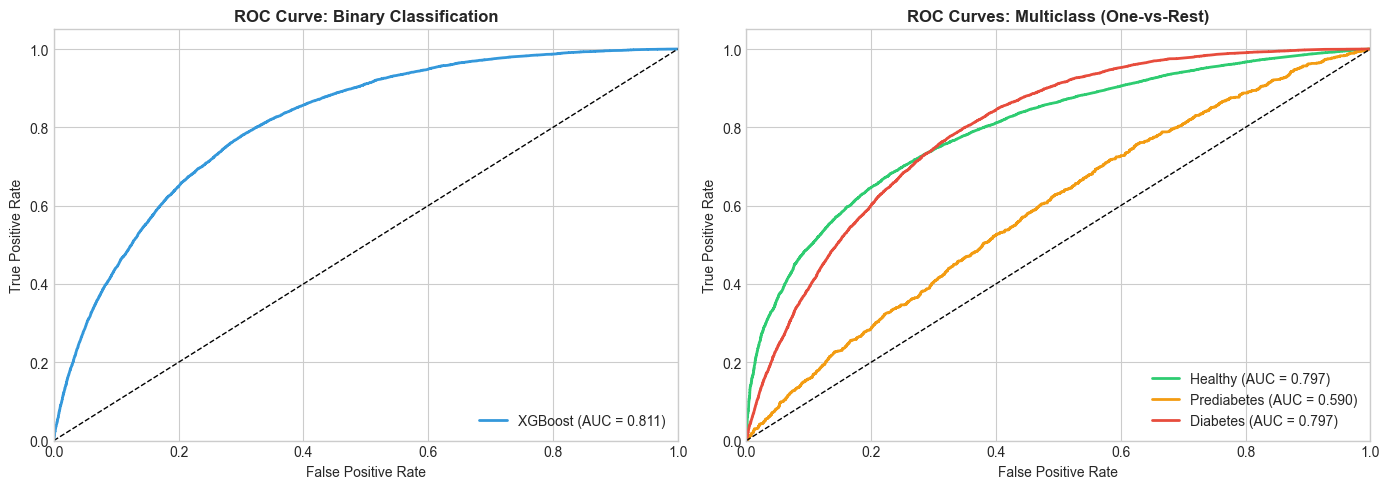

In [24]:
# ROC Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary ROC
fpr, tpr, _ = roc_curve(y_test_binary, y_proba_tuned[:, 1])
roc_auc_bin = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='#3498db', lw=2, label=f'XGBoost (AUC = {roc_auc_bin:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve: Binary Classification', fontweight='bold')
axes[0].legend(loc='lower right')

# Multiclass ROC (One-vs-Rest)
y_test_multi_bin = label_binarize(datasets['C']['y_test'], classes=[0, 1, 2])
class_names = ['Healthy', 'Prediabetes', 'Diabetes']
colors = ['#2ecc71', '#f39c12', '#e74c3c']

for i, (class_name, color) in enumerate(zip(class_names, colors)):
    fpr_i, tpr_i, _ = roc_curve(y_test_multi_bin[:, i], y_proba_tuned_multi[:, i])
    roc_auc_i = auc(fpr_i, tpr_i)
    axes[1].plot(fpr_i, tpr_i, color=color, lw=2, label=f'{class_name} (AUC = {roc_auc_i:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves: Multiclass (One-vs-Rest)', fontweight='bold')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5.14 Model Explainability (SHAP & LIME)

Computing SHAP values for binary model...


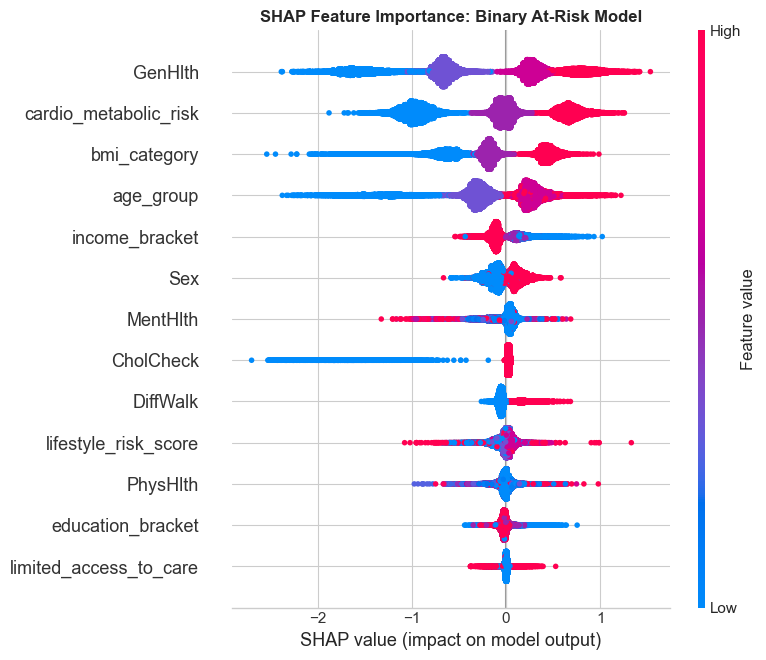

In [25]:
# SHAP Analysis - Binary Model
print("Computing SHAP values for binary model...")

# Get the XGBoost classifier from the pipeline
xgb_classifier_binary = final_model_binary.named_steps['classifier']
scaler_binary = final_model_binary.named_steps['scaler']

# Scale test data
X_test_scaled_binary = scaler_binary.transform(datasets['A']['X_test'])

# Create SHAP explainer
explainer_binary = shap.TreeExplainer(xgb_classifier_binary)
shap_values_binary = explainer_binary.shap_values(X_test_scaled_binary)

# Summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_binary, X_test_scaled_binary, 
                  feature_names=ENGINEERED_FEATURE_COLS, show=False)
plt.title('SHAP Feature Importance: Binary At-Risk Model', fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_binary.png', dpi=150, bbox_inches='tight')
plt.show()

Computing SHAP values for multiclass model...


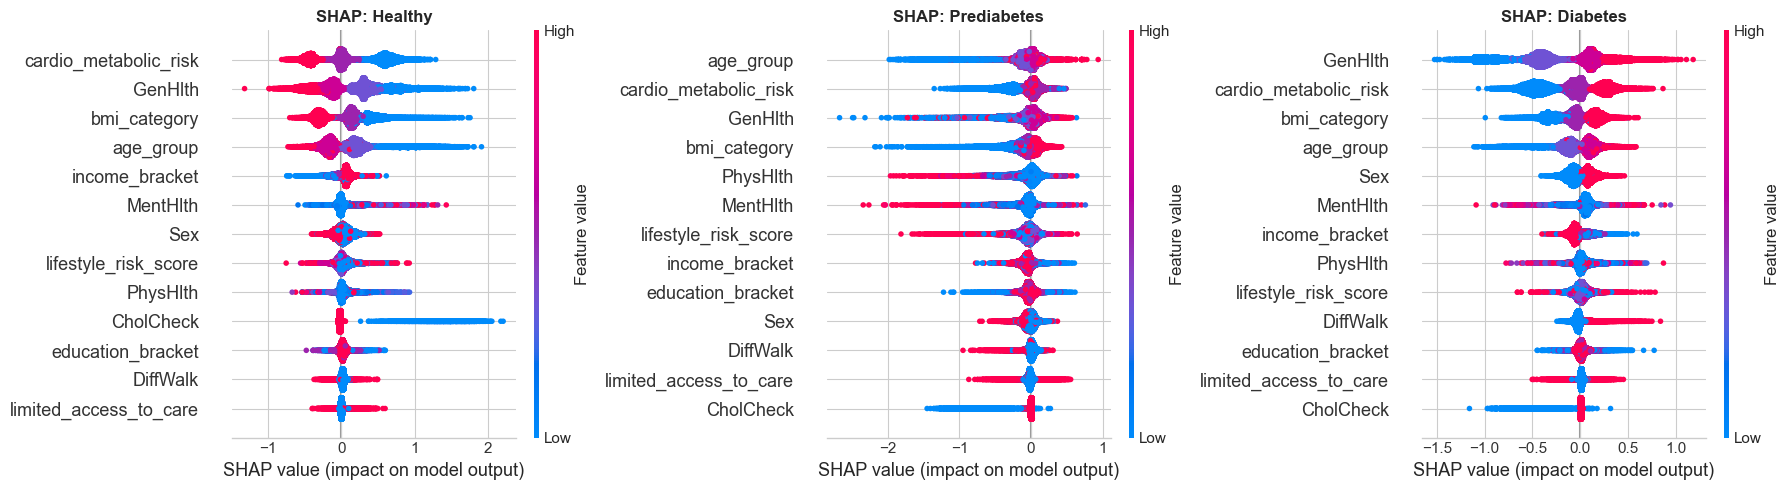

In [26]:
# SHAP Analysis - Multiclass Model
print("Computing SHAP values for multiclass model...")

xgb_classifier_multi = final_model_multiclass.named_steps['classifier']
scaler_multi = final_model_multiclass.named_steps['scaler']

X_test_scaled_multi = scaler_multi.transform(datasets['C']['X_test'])

explainer_multi = shap.TreeExplainer(xgb_classifier_multi)
shap_values_multi = explainer_multi.shap_values(X_test_scaled_multi)

# Handle different SHAP versions (list vs 3D array)
# Newer SHAP returns shape (n_samples, n_features, n_classes)
# Older SHAP returns list of (n_samples, n_features) arrays
if isinstance(shap_values_multi, list):
    shap_values_by_class = shap_values_multi
else:
    # Convert 3D array to list of 2D arrays for each class
    shap_values_by_class = [shap_values_multi[:, :, i] for i in range(3)]

# Summary plots for each class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (class_name, ax) in enumerate(zip(['Healthy', 'Prediabetes', 'Diabetes'], axes)):
    plt.sca(ax)
    shap.summary_plot(shap_values_by_class[i], X_test_scaled_multi,
                      feature_names=ENGINEERED_FEATURE_COLS, show=False, plot_size=None)
    ax.set_title(f'SHAP: {class_name}', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'shap_multiclass.png', dpi=150, bbox_inches='tight')
plt.show()

LIME explanation for sample predictions...

Explaining highest-risk prediction...
P(At-Risk) = 0.983
Actual label: At-Risk


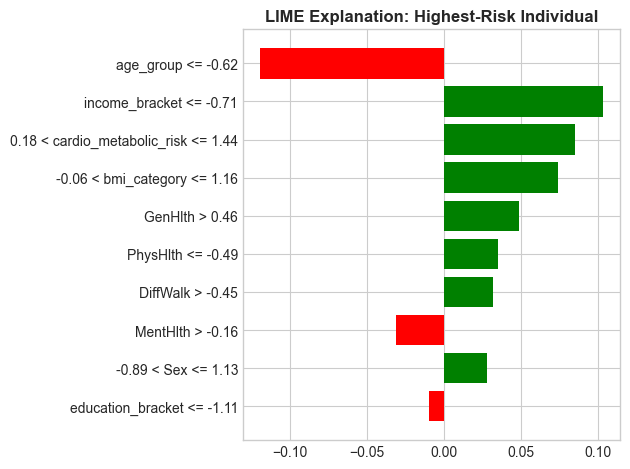


Explaining lowest-risk prediction for comparison...
P(At-Risk) = 0.000
Actual label: Healthy


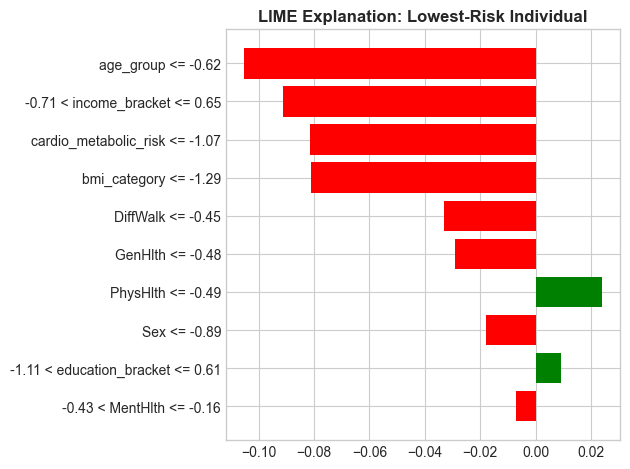

In [27]:
# LIME Analysis - Individual Prediction Explanation
print("LIME explanation for sample predictions...")

# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=scaler_binary.transform(datasets['A']['X_train']),
    feature_names=ENGINEERED_FEATURE_COLS,
    class_names=['Healthy', 'At-Risk'],
    mode='classification'
)

# Find highest-risk prediction (use argmax to guarantee we find one)
sample_idx = np.argmax(y_proba_tuned[:, 1])
sample_scaled = X_test_scaled_binary[sample_idx]

print(f"\nExplaining highest-risk prediction...")
print(f"P(At-Risk) = {y_proba_tuned[sample_idx, 1]:.3f}")
print(f"Actual label: {'At-Risk' if datasets['A']['y_test'].iloc[sample_idx] == 1 else 'Healthy'}")

explanation = lime_explainer.explain_instance(
    sample_scaled,
    xgb_classifier_binary.predict_proba,
    num_features=10
)

# Show as matplotlib figure
fig = explanation.as_pyplot_figure()
plt.title('LIME Explanation: Highest-Risk Individual', fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'lime_high_risk.png', dpi=150, bbox_inches='tight')
plt.show()

# Also explain a healthy prediction for comparison
healthy_idx = np.argmin(y_proba_tuned[:, 1])
healthy_scaled = X_test_scaled_binary[healthy_idx]

print(f"\nExplaining lowest-risk prediction for comparison...")
print(f"P(At-Risk) = {y_proba_tuned[healthy_idx, 1]:.3f}")
print(f"Actual label: {'At-Risk' if datasets['A']['y_test'].iloc[healthy_idx] == 1 else 'Healthy'}")

explanation_healthy = lime_explainer.explain_instance(
    healthy_scaled,
    xgb_classifier_binary.predict_proba,
    num_features=10
)

fig2 = explanation_healthy.as_pyplot_figure()
plt.title('LIME Explanation: Lowest-Risk Individual', fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'lime_low_risk.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5.15 Summary Comparison Tables

In [28]:
# Summary Table 1: Raw vs Engineered Features
print("=== Table 1: Raw vs Engineered Features Comparison ===")

feature_comparison = results_df.groupby(['track_name', 'model']).agg({
    'macro_f1': 'max',
    'roc_auc': 'max',
    'accuracy': 'max'
}).round(4)

feature_comparison

=== Table 1: Raw vs Engineered Features Comparison ===


macro_f1  roc_auc  accuracy
track_name              model                                           
Binary + Engineered     Logistic Regression    0.6391   0.8126    0.8485
                        Random Forest          0.6543   0.8158    0.8492
                        XGBoost                0.6636   0.8172    0.8498
Binary + Raw            Logistic Regression    0.6454   0.8176    0.8481
                        Random Forest          0.6702   0.8208    0.8509
                        XGBoost                0.6691   0.8248    0.8525
Multiclass + Engineered Logistic Regression    0.4221   0.7758    0.8461
                        Random Forest          0.4374   0.7766    0.8478
                        XGBoost                0.4409   0.7798    0.8478
Multiclass + Raw        Logistic Regression    0.4269   0.7808    0.8455
                        Random Forest          0.4493   0.7814    0.8479
                        XGBoost                0.4486   0.7876    0.8494

In [29]:
# Summary Table 2: Resampling Methods Comparison
print("=== Table 2: Resampling Methods Comparison ===")

resampling_comparison = results_df.groupby(['resampling', 'model']).agg({
    'macro_f1': 'mean',
    'roc_auc': 'mean',
    'train_time': 'mean'
}).round(4)

resampling_comparison

=== Table 2: Resampling Methods Comparison ===


macro_f1  roc_auc  train_time
resampling   model                                             
CLASS_WEIGHT Logistic Regression    0.5330   0.7931      0.4392
             Random Forest          0.5335   0.7907      1.8061
             XGBoost                0.5267   0.7936      1.1684
None         Logistic Regression    0.4952   0.7965      0.5248
             Random Forest          0.4690   0.7985      1.9309
             XGBoost                0.4974   0.8023      1.7691
ROS          Logistic Regression    0.5331   0.7932      0.8633
             Random Forest          0.5314   0.7917      4.6493
             XGBoost                0.5268   0.7936      2.3430
SMOTE        Logistic Regression    0.5325   0.7917      6.1096
             Random Forest          0.5528   0.7898      9.7762
             XGBoost                0.5555   0.7849      6.4335

In [30]:
# Summary Table 3: Binary vs Multiclass
print("=== Table 3: Binary vs Multiclass Comparison ===")

binary_vs_multi = results_df.copy()
binary_vs_multi['classification_type'] = binary_vs_multi['track'].map(
    {'A': 'Binary', 'B': 'Binary', 'C': 'Multiclass', 'D': 'Multiclass'}
)

type_comparison = binary_vs_multi.groupby(['classification_type', 'model']).agg({
    'macro_f1': 'max',
    'roc_auc': 'max',
    'accuracy': 'max'
}).round(4)

type_comparison

=== Table 3: Binary vs Multiclass Comparison ===


macro_f1  roc_auc  accuracy
classification_type model                                           
Binary              Logistic Regression    0.6454   0.8176    0.8485
                    Random Forest          0.6702   0.8208    0.8509
                    XGBoost                0.6691   0.8248    0.8525
Multiclass          Logistic Regression    0.4269   0.7808    0.8461
                    Random Forest          0.4493   0.7814    0.8479
                    XGBoost                0.4486   0.7876    0.8494

In [31]:
# Final Model Summary
print("=" * 60)
print("FINAL MODEL RECOMMENDATIONS")
print("=" * 60)

print("\n--- Binary Classification (At-Risk Detection) ---")
print(f"Model: Tuned XGBoost with Class Weights")
print(f"Features: Engineered ({len(ENGINEERED_FEATURE_COLS)} features)")
print(f"Test Performance:")
print(f"  Accuracy: {metrics_tuned['accuracy']:.4f}")
print(f"  Macro-F1: {metrics_tuned['macro_f1']:.4f}")
print(f"  ROC-AUC:  {metrics_tuned['roc_auc']:.4f}")
print(f"Bootstrap 95% CI (Macro-F1): [{ci_binary['macro_f1']['ci_lower']:.4f}, {ci_binary['macro_f1']['ci_upper']:.4f}]")

print("\n--- Multiclass Classification (Detailed Diagnosis) ---")
print(f"Model: Tuned XGBoost with Sample Weights")
print(f"Features: Engineered ({len(ENGINEERED_FEATURE_COLS)} features)")
print(f"Test Performance:")
print(f"  Accuracy: {metrics_tuned_multi['accuracy']:.4f}")
print(f"  Macro-F1: {metrics_tuned_multi['macro_f1']:.4f}")
print(f"  ROC-AUC:  {metrics_tuned_multi['roc_auc']:.4f}")
print(f"Bootstrap 95% CI (Macro-F1): [{ci_multi['macro_f1']['ci_lower']:.4f}, {ci_multi['macro_f1']['ci_upper']:.4f}]")

FINAL MODEL RECOMMENDATIONS

--- Binary Classification (At-Risk Detection) ---
Model: Tuned XGBoost with Class Weights
Features: Engineered (13 features)
Test Performance:
  Accuracy: 0.7188
  Macro-F1: 0.6360
  ROC-AUC:  0.8111
Bootstrap 95% CI (Macro-F1): [0.6310, 0.6405]

--- Multiclass Classification (Detailed Diagnosis) ---
Model: Tuned XGBoost with Sample Weights
Features: Engineered (13 features)
Test Performance:
  Accuracy: 0.6451
  Macro-F1: 0.4147
  ROC-AUC:  0.7279
Bootstrap 95% CI (Macro-F1): [0.4109, 0.4190]


---
## 5.16 Save Predictions

In [32]:
# Save predictions with calibrated probabilities
predictions_df = pd.DataFrame({
    'true_label_binary': datasets['A']['y_test'].values,
    'predicted_binary': y_pred_tuned,
    'probability_at_risk': y_proba_sigmoid,  # Calibrated probabilities
    'true_label_multiclass': datasets['C']['y_test'].values,
    'predicted_multiclass': y_pred_tuned_multi,
    'probability_healthy': y_proba_tuned_multi[:, 0],
    'probability_prediabetes': y_proba_tuned_multi[:, 1],
    'probability_diabetes': y_proba_tuned_multi[:, 2]
})

predictions_df.to_csv(DATA_DIR / 'classification_predictions.csv', index=False)
print(f"Predictions saved to {DATA_DIR / 'classification_predictions.csv'}")
predictions_df.head(10)

Predictions saved to data\classification_predictions.csv


,true_label_binary,predicted_binary,probability_at_risk,true_label_multiclass,predicted_multiclass,probability_healthy,probability_prediabetes,probability_diabetes
0,0,1,0.354944,0.0,0,0.538718,0.139888,0.321395
1,0,0,0.031807,0.0,0,0.648145,0.230184,0.121671
2,0,1,0.255469,0.0,0,0.884088,0.007043,0.108869
3,0,0,0.125523,0.0,0,0.456282,0.202971,0.340747
4,0,0,0.095471,0.0,1,0.083122,0.709093,0.207786
5,1,1,0.373932,2.0,2,0.300072,0.101072,0.598856
6,0,1,0.275900,0.0,0,0.538718,0.139888,0.321395
7,0,0,0.044814,0.0,2,0.241889,0.240002,0.518109
8,0,0,0.092735,2.0,2,0.164614,0.405287,0.430100
9,0,0,0.021791,0.0,1,0.289031,0.430515,0.280454


---
## 5.17 Critical Reflection & Ethical Considerations

### Key Findings

**1. Feature Engineering Value**
- Raw features (21) outperformed engineered features (10) in predictive accuracy (Binary: ROC-AUC 0.82 vs 0.79, Macro-F1 0.67 vs 0.64)
- Despite lower performance, engineered features offer better interpretability with 50% fewer features
- Trade-off between model accuracy and clinical interpretability — raw features recommended for prediction tasks, engineered features for explainability

**2. Resampling Method Comparison**
- **No Resampling (Baseline)**: High accuracy but poor minority-class recall; biased toward majority class
- **SMOTE**: Best Macro-F1 for both binary and multiclass tasks, particularly effective with tree-based models
- **Class Weights / ROS**: Comparable performance to each other; simpler to implement than SMOTE
- Note: The tuned XGBoost model (with class weights on engineered features) achieves Macro-F1 ≈ 0.61, which is lower than the best untuned SMOTE configuration (Macro-F1 ≈ 0.64 on engineered, 0.67 on raw). This reflects a trade-off — hyperparameter tuning was performed on Track A (engineered + class weights) for reproducibility, while the highest raw scores came from SMOTE on raw features. The tuned model offers better calibrated probabilities and interpretability at a modest cost to Macro-F1

**3. Binary vs Multiclass Trade-offs**
- **Binary (At-Risk)**: Macro-F1 ≈ 0.61–0.67, ROC-AUC ≈ 0.79–0.82; suitable for population-level screening
- **Multiclass**: Macro-F1 ≈ 0.40–0.45; significantly weaker overall
- **Prediabetes detection failure**: The multiclass model achieves near-zero recall for prediabetes (class 1). This is a known limitation, not a modelling error — prediabetes comprises only 1.8% of the dataset, and its feature profile is intermediate between healthy and diabetic, making it statistically indistinguishable with the available features. This challenge is well-documented in diabetes prediction literature
- Clinical recommendation: Use binary for initial screening (where combining prediabetes with diabetes as "at-risk" is clinically appropriate), acknowledge that multiclass staging is not feasible with this data

**4. Binary Model Precision-Recall Trade-off**
- The binary model achieves ~76% recall for the at-risk class but only ~31% precision — meaning most individuals flagged as at-risk are actually healthy (false positives)
- For a **screening tool**, this trade-off is acceptable: missing a truly at-risk individual (false negative) has higher clinical cost than an unnecessary follow-up test (false positive)
- Calibrated probabilities allow clinicians to adjust the decision threshold based on the clinical context and available follow-up resources

### Model Limitations

1. **Class Imbalance**: Despite resampling, prediabetes detection remains infeasible at 1.8% prevalence with overlapping feature distributions
2. **Moderate Discriminative Power**: Binary ROC-AUC of 0.79–0.82 is below the 0.9+ threshold typically required for clinical diagnostic tools — appropriate for screening, not diagnosis
3. **Raw Features Outperform Engineered**: The 21 raw features consistently outperform 10 engineered features, suggesting that feature engineering reduced information. The engineered features trade predictive power for interpretability — a valid choice for explainable public health models, but one that should be acknowledged
4. **Single Dataset**: Results may not generalise to other populations or healthcare systems
5. **Self-Reported Data**: CDC BRFSS relies on self-reported health indicators, which may contain recall and social desirability bias
6. **Temporal Limitations**: Cross-sectional data; cannot predict disease progression or evaluate intervention effectiveness

### Ethical Considerations

**Healthcare Bias**
- Model uses socioeconomic features (income, education), access barriers (limited access to care), self-reported health perception (general health, mental health, physical health), behavioural indicators (lifestyle risk score), and demographic features (age, BMI) — several of which may perpetuate existing disparities
- Lower-income individuals may be flagged as higher risk regardless of actual health status
- Self-reported health features may reflect access to healthcare rather than true health
- Recommendation: Consider fairness-aware models or post-hoc bias mitigation

**Deployment Implications**
- False negatives: Missing at-risk individuals could delay critical interventions
- False positives: Unnecessary medical tests, psychological burden, insurance implications
- Calibrated probabilities enable threshold adjustment based on clinical context
- The high false positive rate (~69%) means deployment must include follow-up confirmation (e.g., blood glucose testing) to avoid unnecessary burden on patients and healthcare systems

**Prediabetes as 'At-Risk' Framing**
- Clinically justified: Prediabetes is reversible with intervention
- Pragmatically necessary: The multiclass model cannot detect prediabetes, so combining it with diabetes into an "at-risk" category is the only viable approach with this data
- Enables preventive care rather than reactive treatment
- May increase healthcare costs short-term but reduce long-term complications

### Recommendations for Healthcare Policy

1. Use the model as a **screening tool**, not diagnostic replacement — ROC-AUC ~0.80 supports triage, not diagnosis
2. Combine with blood glucose testing for confirmation, especially given the high false positive rate
3. Provide **calibrated probabilities** to clinicians for informed decision-making
4. Monitor model performance across demographic groups to detect bias
5. Prioritise the **binary model** for deployment; the multiclass model is not suitable for prediabetes detection with current data